In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nb
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import cm
import statsmodels.api as sm
import os
import pandas as pd

/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: Runti

In [2]:
rootdir='/data1/users/kwagstyl/bigbrain/Hierarchy/'
geodesicdir='/data1/users/kwagstyl/bigbrain/Hierarchy/geodesics/'
figdir='/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/'
surfdir='/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/'

In [3]:
systems = ['visual','somatosensory','auditory','motor']
hemis=['left','right']
font = {'family' : 'sans-serif',
        'style':'normal',
        'size'   : 30}


In [4]:
#import thicknesses
thickness={}
for layer in np.arange(6):
    thickness['layer_{}'.format(layer+1)]=np.loadtxt(os.path.join(rootdir,'thickness_left_layer{}.txt'.format(layer+1)))[:163842]
thickness['total']=np.loadtxt(os.path.join(rootdir,'thickness_left_total.txt'))

In [ ]:
#import profiles
#geo = np.loadtxt('/data1/users/kwagstyl/padl_data/euclid_geo_profiles_left.txt')[:163842]


In [6]:
#import geodesics and masks
geodesics={}
masks={}
system_max={}
for system in systems:
    regions=np.loadtxt(os.path.join(geodesicdir,system+'_regions_left.txt')).astype(bool)[:163842]
    archi_mask=np.loadtxt(os.path.join(surfdir,'archi_left.txt')).astype(bool)[:163842]
    regions=np.logical_and(regions,1-archi_mask)
    mask=np.loadtxt(os.path.join(geodesicdir,'tear_mask_left.txt')).astype(bool)[:163842]
    distances=np.loadtxt(os.path.join(geodesicdir,system+'_geodesic_distances_left.txt'))[:163842]
    
    regions=np.logical_and(regions,1-mask)
    distances[~regions]=1000
    geodesics[system]=distances
    masks[system]=regions
    system_max[system]=np.max(distances[regions])

In [12]:
#create thicknesses image gradient image
#moving mean
window_size=20
window_spacing=5
#number of profiles in each window to sample
n_samples = 10
layer_thicknesses={}
profile_samples={}
for system in systems:
    n_bins=np.round(system_max[system]//window_spacing).astype(int)
    layer_thicknesses[system]=np.zeros((6,n_bins))
    profile_samples[system]=np.zeros((n_bins,200))
    for midpoint in np.arange(n_bins):
        mid=midpoint*window_spacing
        window = np.logical_and(geodesics[system]>(mid-window_size/2),geodesics[system]<(mid+window_size/2))
        if sum(window)<1000:
            break
        for layer in np.arange(6):
            layer_thicknesses[system][layer,midpoint] = np.mean(thickness['layer_{}'.format(layer+1)][window])
        examples=np.random.choice(sum(window),n_samples)
    #    system_samples=geo[window]
     #   profile_samples[system][midpoint,:]=system_samples[0]

In [13]:
from matplotlib import rc

def plot_layers_bins(layer_thicknesses,system='visual',legend=False):
    import matplotlib
    font = {'family' : 'sans-serif',
            'style':'normal',
            'size'   : 20,
            }
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    matplotlib.rc('font', **font)
    Layers=['I', 'II','III', 'IV', 'V', 'VI']
    n_bins=sum(layer_thicknesses[system][0,:]>0)
    ind=np.arange(n_bins)*window_spacing
    width=window_spacing
    colours=np.array([50,200,150,250,200,100])
    cmap=plt.get_cmap('Greys')
    Plots={}
    bottom=np.zeros(n_bins)
    
    f=plt.figure(figsize=(8,4))
    plt.tight_layout()
    for layer in 5-np.arange(6):
        Plots["p{0}".format(layer+1)] = plt.bar(ind, layer_thicknesses[system][layer,:n_bins], width, color=cmap(colours[layer]),bottom=bottom)

        bottom+=layer_thicknesses[system][layer,:n_bins]

    
    # plt.tick_params(
    #     axis='x',          
    #     which='both',      
    #     bottom=False,      
    #     top=False)
    ax = plt.subplot(111)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.ylim([0,3])
    plt.xticks([])
    plt.yticks([])
    #plt.xlabel('Geodesic distance')
    #plt.ylabel('Cortical thickness (mm)')
    if legend:
        plt.legend((Plots['p1'],Plots['p2'],Plots['p3'],Plots['p4'],Plots['p5'],Plots['p6']),Layers,title='Layer',bbox_to_anchor=(1,0.8))
    return f

/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/users/kwagstyl/anaconda3/lib/python3

/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotli

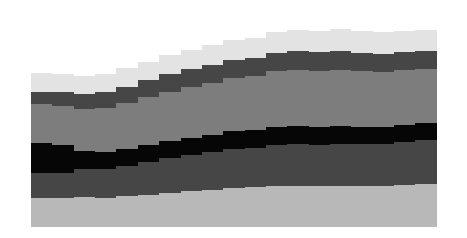

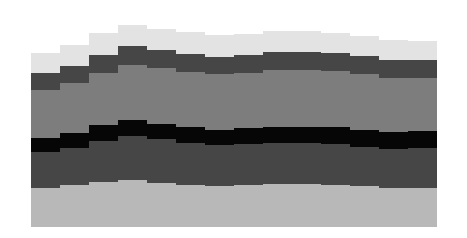

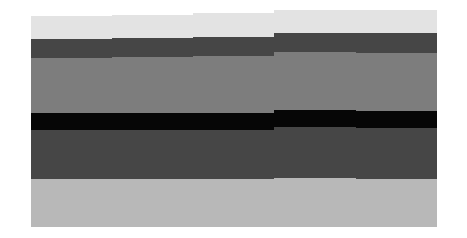

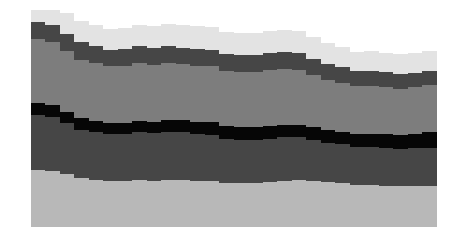

/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotli

/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/matplotli

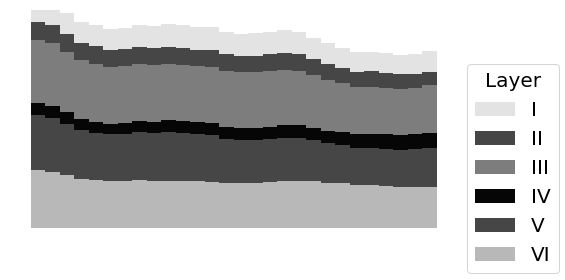

In [14]:
for system in systems:
    fig=plot_layers_bins(layer_thicknesses,system=system)
    fig.savefig(os.path.join(figdir,'layers_stacked_{}.pdf'.format(system)))
    
fig=plot_layers_bins(layer_thicknesses,system=system,legend=True)
fig.savefig(os.path.join(figdir,'legend.pdf'.format(system)))

TypeError: Invalid dimensions for image data

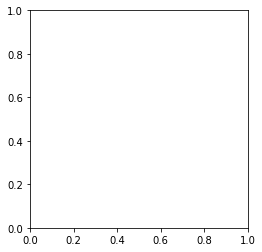

In [170]:
#create profiles image
#mean moving 
plt.imshow(profile_samples[system][15])

In [178]:
plt.imshow(np.repeat(profile_samples[system][15],5,axis=1))

AxisError: axis 1 is out of bounds for array of dimension 1

In [199]:
profiles_=[]
for profile in profile_samples[system]:
    profiles_.append(np.tile(profile,(10,1)))

In [204]:
profiles_=np.reshape(profiles_,(300,200))

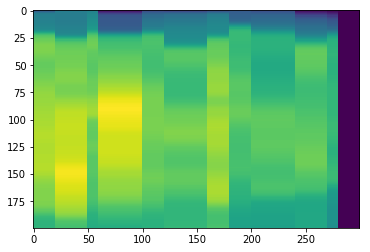

In [207]:
plt.imshow(profiles_.T)

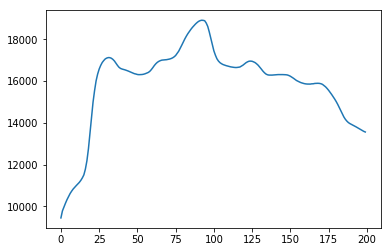

In [212]:
plt.plot(profiles_[50])